In [1]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import scipy.optimize as sc

In [3]:
# Define a function to download stock data
def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data
# Define a function to calculate annualized returns and covariance matrix
def calculate_returns_and_covariance(data):
    daily_returns = data.pct_change().dropna()
    annual_returns = daily_returns.mean() * 252
    covariance_matrix = daily_returns.cov() * 252
    return annual_returns, covariance_matrix
# Define a function to calculate portfolio performance
def portfolio_performance(weights, returns, covariance_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_return, portfolio_risk
# Define a function to minimize negative Sharpe Ratio
def negative_sharpe_ratio(weights, returns, covariance_matrix, risk_free_rate=0.01):
    p_return, p_risk = portfolio_performance(weights, returns, covariance_matrix)
    return -(p_return - risk_free_rate) / p_risk

In [6]:
def get_efficient_frontier(returns, covariance_matrix, num_portfolios=10000):
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(len(returns))
        weights /= np.sum(weights)
        # Calculate portfolio performance and assign values
        portfolio_return, portfolio_risk = portfolio_performance(weights, returns, covariance_matrix)
        results[0,i] = portfolio_return # Store return
        results[1,i] = portfolio_risk  # Store risk
        results[2,i] = portfolio_return / portfolio_risk # Store sharpe ratio
        weights_record.append(weights)

    return results, weights_record

In [7]:
def plot_efficient_frontier(results):
    max_sharpe_idx = np.argmax(results[2])
    min_risk_idx = np.argmin(results[1])
    sdp, rp = results[1, max_sharpe_idx], results[0, max_sharpe_idx]
    # Extract standard deviation and return for minimum risk portfolio
    min_risk_sdp, min_risk_rp = results[1, min_risk_idx], results[0, min_risk_idx]


    plt.figure(figsize=(15, 9))
    plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(sdp, rp, marker='*', color='r', s=400, label='Max Sharpe Ratio')
    plt.scatter(min_risk_sdp, min_risk_rp, marker='*', color='b', s=400, label='Min Risk') # Now min_risk_sdp and min_risk_rp are defined
    plt.title('Efficient Frontier')
    plt.xlabel('Risk (Standard Deviation)')
    plt.ylabel('Return')
    plt.legend(loc='upper right')
    plt.show()
    print(f"Max Sharpe Ratio Portfolio: Return = {round(rp, 2)}, Risk = {round(sdp, 2)}")
    print(f"Min Risk Portfolio: Return = {round(min_risk_rp, 2)}, Risk = {round(min_risk_sdp, 2)}")

[*********************100%%**********************]  4 of 4 completed


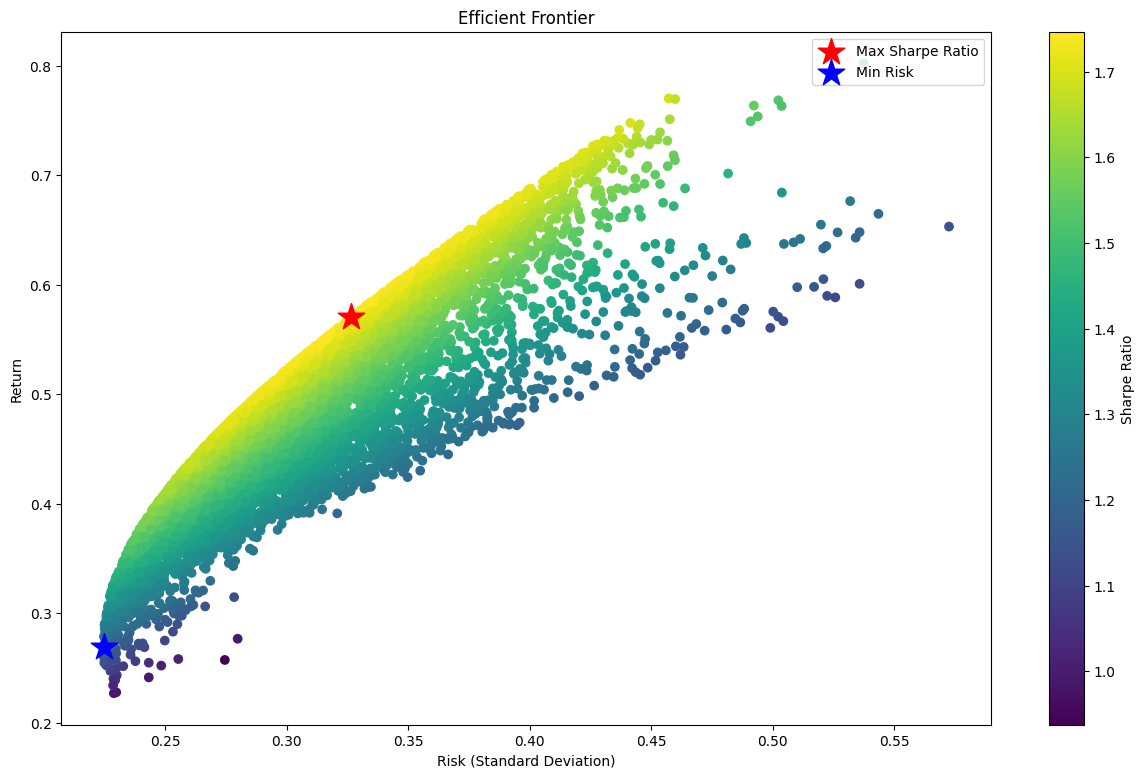

Max Sharpe Ratio Portfolio: Return = 0.57, Risk = 0.33
Min Risk Portfolio: Return = 0.27, Risk = 0.22


In [51]:
def main():
    global tickers
    tickers = ['ASIANPAINT.NS', 'INFY.NS', 'TATASTEEL.NS', 'ADANIENT.NS']
    start_date = '2020-01-01'
    end_date = '2024-01-01'
    data = download_data(tickers, start_date, end_date)
    returns, covariance_matrix = calculate_returns_and_covariance(data)
    results, weights_record = get_efficient_frontier(returns, covariance_matrix)

    plot_efficient_frontier(results)



if __name__ == '__main__':
    main()

In [52]:
def maxSR(meanreturn, covmatrix, riskfreerate = 0.01, constraintSet=(0,1)):

    numAssets = len(tickers)
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple(constraintSet for asset in range(numAssets))
    args = (meanreturn, covmatrix, riskfreerate)
    val = sc.minimize(negative_sharpe_ratio, numAssets*[1./numAssets,], args=args,method='SLSQP', bounds=bounds, constraints=constraints) 
    return val


In [53]:
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Adj Close']
meanreturns ,cov_matrix = calculate_returns_and_covariance(data)
values = maxSR(meanreturns, cov_matrix)
maximum_sharpe_ratio, maximum_weights = values['fun'], values['x']
print(-maximum_sharpe_ratio, maximum_weights)

[*********************100%%**********************]  4 of 4 completed

1.7161420586773546 [0.41370653 0.14222975 0.21804049 0.22602323]
